In [214]:
import pandas as pd
%matplotlib inline
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from pandas import DataFrame,concat,Series
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense

In [109]:
weather=pd.read_csv("temperature.csv")

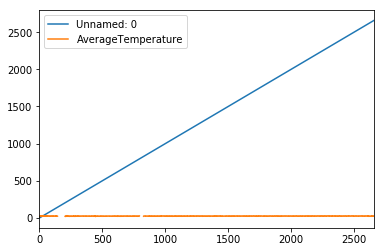

In [110]:
weather.plot()

In [111]:
t=weather["AverageTemperature"]

In [112]:
t=t.dropna()

In [113]:
t=list(t)

In [114]:
from sklearn.model_selection import train_test_split as tts

In [115]:
train_set,test_set=tts(t,test_size=0.1,random_state=44)
train_set=list(train_set)
test_set=list(test_set)


In [116]:
history = [x for x in train_set]
predictions = list()
for i in range(len(test_set)):
    predictions.append(history[-1])
    history.append(test_set[i])

rmse = sqrt(mean_squared_error(test_set, predictions))

In [117]:
rmse

2.7775759505143296

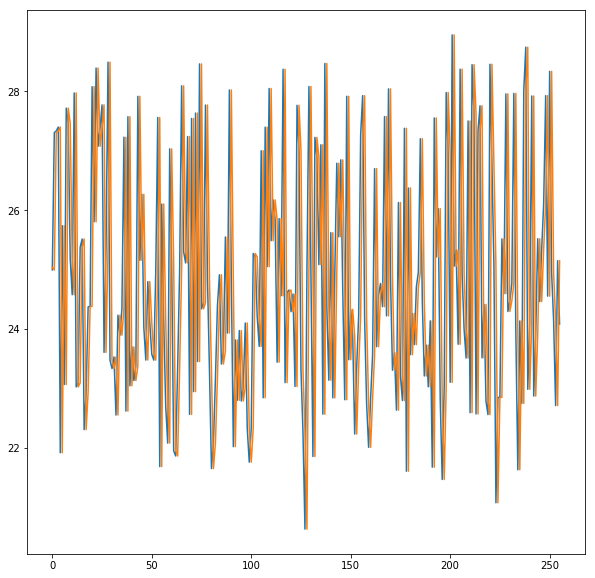

In [118]:
plt.figure(figsize=(10,10))
pyplot.plot(test_set)
pyplot.show()


In [194]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [195]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [196]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [197]:
z = difference(t, 1)
temp=timeseries_to_supervised(z,lag=1)

In [200]:
train_set,test_set=tts(temp,test_size=0.1,random_state=44)

In [206]:
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [215]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [210]:
scaler, train_scaled, test_scaled = scale(train_set.values, test_set.values)

In [216]:
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)

TypeError: Expected int32, got list containing Tensors of type '_Message' instead.

In [130]:
inverted=[]
for i in range(len(z)):
	value = inverse_difference(t, z[i], len(t)-i)
	inverted.append(value)
inverted = Series(z)

In [146]:
tet=np.asarray(t).reshape(len(t),1)

In [148]:
scaler =MinMaxScaler(feature_range=(-1,1))
scaler=scaler.fit(tet)
scaled_X=scaler.transform(tet)

In [151]:
inverted_X = scaler.inverse_transform(scaled_X)

In [158]:
temp
X=temp.iloc[:,0:-1]

In [161]:
y=temp.iloc[:,-1]

In [181]:
X=X.values.reshape(X.shape[0],1,X.shape[1])

In [182]:
X
#train is temp in the next function

array([[[  0.        ]],

       [[ 22.672     ]],

       [[ 24.42      ]],

       ..., 
       [[ 23.75447154]],

       [[ 23.60666667]],

       [[ 23.64634146]]])

In [192]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [193]:
def forecast(model, batch_size, row):
	X = row[0:-1]
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]